In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

from os import path

from utils import SimulateData
from stopsignalmetrics import SSRTmodel, StopData

from scipy.stats import exponnorm, norm, norminvgauss
from scipy import stats

from generate_remaining_sim_cmds import replace

ModuleNotFoundError: No module named 'utils'

In [2]:
OVERWRITE_MUS = False

# __Preprocessing__

## 1. Prepare data for use by stopsignalmetrics

In [3]:
abcd_data = pd.read_csv('abcd_data/abcd_w_finger_press.csv')

In [4]:
len(abcd_data.NARGUID.unique())

8464

In [5]:
for rt_col in ['go_rt_adjusted', 'stop_rt_adjusted']:
    abcd_data.loc[abcd_data['finger_press'].isnull(), rt_col] = np.nan

In [6]:
abcd_data['block'] = np.NaN
abcd_data.loc[abcd_data['TrialNum'] < 180, 'block'] = '1'
abcd_data.loc[abcd_data['TrialNum'] >= 180, 'block'] = '2'

In [7]:
abcd_data['choice_accuracy'] = np.where(
    abcd_data['finger_press'].notnull(),
    np.where(
        abcd_data['finger_press']==abcd_data['correct_response'],
        1,
        0),
    np.nan
)

In [8]:
len(abcd_data.NARGUID.unique())

8464

## 1.5 replace IDs with ` (backticks) in them
#### shell scripts do not interpret them well

In [9]:
def strip_backticks(string):
    return string.replace('`', '')

In [10]:
original_unique_IDs = abcd_data.NARGUID.unique()
fix_id_map = {i:strip_backticks(i) for i in abcd_data.NARGUID.unique() if '`' in i}
abcd_data.NARGUID = abcd_data.NARGUID.replace(fix_id_map)
assert len(original_unique_IDs)==len(abcd_data.NARGUID.unique())

In [11]:
abcd_data.to_csv('abcd_data/minimal_abcd_with_issue_3.csv', index=False)

## 2. Drop Issue 3 people

In [12]:
abcd_data_w_issue_3 = pd.read_csv('abcd_data/minimal_abcd_with_issue_3.csv')

In [13]:
abcd_data_w_issue_3['correct_go_response'].unique()

array([ 1.,  0., nan])

In [14]:
issue_3_people = abcd_data_w_issue_3.loc[(abcd_data_w_issue_3['stop_rt_adjusted'] < 50) & (abcd_data_w_issue_3['stop_rt_adjusted'] > 0) & (abcd_data_w_issue_3['SSDDur'] ==50), 'NARGUID'].unique()

print('n affected:', len(issue_3_people))
print('p affect:', len(issue_3_people)/ 7231)

abcd_data = abcd_data_w_issue_3[~abcd_data_w_issue_3.NARGUID.isin(issue_3_people)].copy()
print('n remaining:', abcd_data.NARGUID.nunique())

n affected: 226
p affect: 0.03125432167058498
n remaining: 8238


In [15]:
abcd_data.to_csv('abcd_data/minimal_abcd_clean.csv', index=False)

# __Metrics for Simulation__

In [16]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

## 1. get a distribution of mean go RTs and SSRTs to sample from

In [17]:
variable_dict = {
   "columns": {
      "ID": "NARGUID", #subject identifier
      "condition": "trial_type", #col with trial types 
      "correct_response": "correct_response", #col with correct reponse codes
      "response": "finger_press", #col with actual response codes 
      "SSD": "SSDDur", #col with stop signal delay 
      "block": "block", #col with which block a trial is accuring during
      "goRT": "go_rt_adjusted", # col with go reaction time recording 
      "stopRT": "stop_rt_adjusted", #col with stop failure reaction time recording
      "choice_accuracy": "choice_accuracy" #col with whether a response was correct
   },
   "key_codes": {
      "go": "GoTrial", # cell values for go trials  
      "stop": "StopTrial",  #cell values for stop trials 
      "correct": 1.0,
       "incorrect": 0.0,
       "noResponse": np.nan
   }
}

In [18]:
abcd_ssrt = StopData(var_dict=variable_dict, compute_acc_col=False)

abcd_proc = abcd_ssrt.fit_transform(abcd_data) 

ssrt_model = SSRTmodel(model='replacement')

ssrt_metrics = ssrt_model.fit_transform(abcd_proc, level='group')

problem_subs = ssrt_metrics[ssrt_metrics.SSRT.isnull()].index

print(f'dropping {len(problem_subs)} subs for having P(respond|signal) == 1 or 0')

ssrt_metrics = ssrt_metrics[ssrt_metrics.SSRT.notnull()].copy()

/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dropping 31 subs for having P(respond|signal) == 1 or 0


In [19]:
ssrt_metrics.to_csv('abcd_data/abcd_ssrt_metrics.csv')

In [20]:
# def get_mus(sub_row):
#     sub_row = sub_row.copy()
#     mu_dict = {}
#     # init go and stop vars
#     g = Symbol('g')
#     s = Symbol('s')
    
#     # formulas (must be solved as "expression = 0")
#     # subject_{go/ss}rt = threshold/mu_go + nondecision_time
#     # threshold = 100
#     # nondecision_time = 50
    
#     go_sol = solve((sub_row['mean_go_RT'].values[0] - 50) * g - 100, g)
# #     go_sol = solve(100/g + 50 - sub_row['mean_go_RT'].values[0], g)
#     assert len(go_sol) == 1, f"{len(go_sol)} solutions found based on {sub_row['mean_go_RT']}: {go_sol}"
#     mu_dict['go'] = float(go_sol[0])
    
#     stop_sol = solve(100/s + 50 - sub_row['SSRT'].values[0], s)
#     assert len(stop_sol) == 1, f"{len(stop_sol)} solutions found based on {sub_row['SSRT']}: {stop_sol}"
#     mu_dict['stop'] = float(stop_sol[0])
    
#     return mu_dict

# mu_df = ssrt_metrics.groupby('ID').apply(get_mus)
# mu_dict = mu_df.to_dict()
# mu_dict['prob_subs'] = list(problem_subs)
# mu_df = mu_df.apply(pd.Series)

# json_mu_path = 'abcd_data/individual_mus.json'
# with open(json_mu_path, 'w') as jp:
#     json.dump(mu_dict, jp)

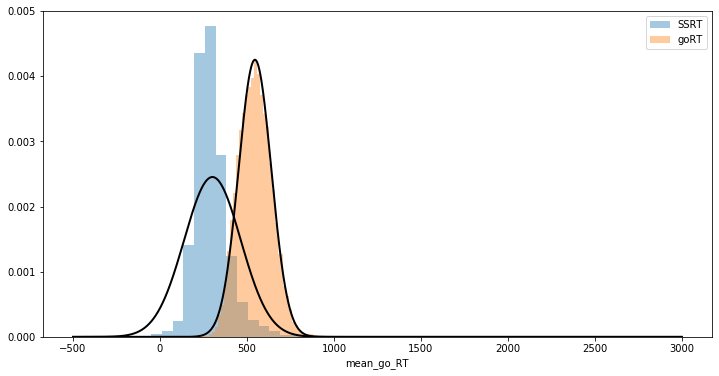

In [21]:
fig = plt.figure(figsize=(12,6))
ax = sns.distplot(ssrt_metrics['SSRT'], kde=False, norm_hist=True, label='SSRT')
ssrt_loc,ssrt_var = norm.fit(ssrt_metrics['SSRT'])
xx = np.arange(-500, 3000, 1)
ax.plot(xx, norm.pdf(xx, loc=ssrt_loc, scale=ssrt_var), 'k', lw=2)  
_ = sns.distplot(ssrt_metrics['mean_go_RT'], kde=False,norm_hist=True, ax=ax, label='goRT')
goRT_loc,goRT_var = norm.fit(ssrt_metrics['mean_go_RT'])
ax.plot(xx, norm.pdf(xx, loc=goRT_loc, scale=goRT_var), 'k', lw=2) 
_ = plt.legend()

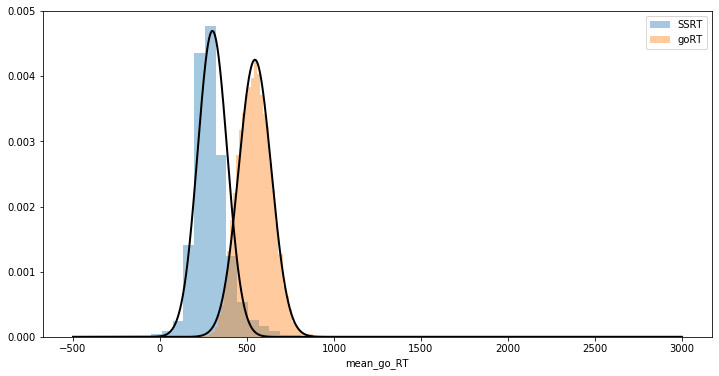

In [22]:
# repeating but giving a reasonable scale for the SSRT distribution

fig = plt.figure(figsize=(12,6))
ax = sns.distplot(ssrt_metrics['SSRT'], kde=False, norm_hist=True, label='SSRT')
xx = np.arange(-500, 3000, 1)
ax.plot(xx, norm.pdf(xx, loc=ssrt_loc, scale=85), 'k', lw=2)  
_ = sns.distplot(ssrt_metrics['mean_go_RT'], kde=False,norm_hist=True, ax=ax, label='goRT')
ax.plot(xx, norm.pdf(xx, loc=goRT_loc, scale=goRT_var), 'k', lw=2) 
_ = plt.legend()

## 1. get SSD distributions per subject

In [23]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [24]:
SSD_dist = abcd_data.groupby('NARGUID')['SSDDur'].value_counts(normalize=True)
SSD_dist.name = 'proportion'
SSD_dist = SSD_dist.reset_index()

In [25]:
SSD_dist.to_csv('abcd_data/SSD_dist_by_subj.csv', index=False)

In [26]:
SSD_dist

,NARGUID,SSDDur,proportion
0,003RTV85,300.0,0.250000
1,003RTV85,250.0,0.183333
2,003RTV85,400.0,0.183333
3,003RTV85,350.0,0.166667
4,003RTV85,450.0,0.100000
...,...,...,...
75313,xxmy9wd8,100.0,0.183333
75314,xxmy9wd8,150.0,0.133333
75315,xxmy9wd8,200.0,0.116667
75316,xxmy9wd8,250.0,0.100000


# 1.5 Sample Mus if necessary

assigning mus


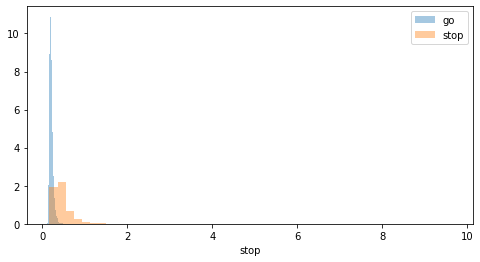

In [28]:
def convert_to_mu(rt, thresh=100, ndt=50):
    # example solve:
    # Threshold = mu * (rt - non-decision-time)
    # Threshold / (rt - ndt) = mu
    return thresh/(rt-ndt)

def sample(mean, scale, ndt=50):
    tmp = np.random.normal(loc=mean, scale=scale)
    # if it is less that the non-decision-time, you get negative mus
    # if it is close to the nondecision time, you get HUGE mus
    while tmp < ndt+10: 
        tmp = np.random.normal(loc=mean, scale=scale)
    return tmp

write_out_path = 'abcd_data/assigned_mus.json'
if not path.exists(write_out_path) or OVERWRITE_MUS:
    print('assigning mus')
    mus_dict = {}
    for sub in SSD_dist.NARGUID.unique():
        mus_dict[sub] = {}
        mus_dict[sub]['goRT'] = sample(mean=goRT_loc, scale=goRT_var)
        mus_dict[sub]['go'] = convert_to_mu(mus_dict[sub]['goRT'])
        mus_dict[sub]['SSRT'] = sample(mean=ssrt_loc, scale=85) # HARD CODED SCALE FOR BETTER FIT
        mus_dict[sub]['stop'] = convert_to_mu(mus_dict[sub]['SSRT']) 
    with open(write_out_path, 'w') as jp:
        json.dump(mus_dict, jp)    
            
    # visualize
    mu_df = pd.DataFrame(mus_dict).T
    fig = plt.figure(figsize=(8,4))
    ax = sns.distplot(mu_df['go'], kde=False, norm_hist=True, label='go')
    _ = sns.distplot(mu_df['stop'], kde=False,norm_hist=True, ax=ax, label='stop')
    _ = plt.legend()

In [29]:
SSD_dist.NARGUID.unique()

array(['003RTV85', '007W6H7B', '00CY2MDM', ..., 'wzrf2ge6', 'x8k59',
       'xxmy9wd8'], dtype=object)

# Exgauss metrics

In [10]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSD0_RTs = abcd_data.query(
    "SSDDur == 0.0 and correct_stop==0.0"
    ).stop_rt_adjusted.values

FIT_K, FIT_LOC, FIT_SCALE = sstats.exponnorm.fit(SSD0_RTs)
FIT_LAMBDA = 1/(FIT_K*FIT_SCALE)
FIT_BETA = 1/FIT_LAMBDA

In [11]:
exgaus_params = {
    'K': FIT_K,
    'loc': FIT_LOC,
    'scale': FIT_SCALE,
    'lambda': FIT_LAMBDA,
    'beta': FIT_BETA,
}

with open('abcd_data/exgauss_params.json', 'w') as f:
    json.dump(exgaus_params, f)

## 2. P(guess|SSD) for mixture distributions

In [31]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSDs = abcd_data.SSDDur.unique()
SSDs = [i for i in SSDs if i == i]
SSDs.sort()

In [32]:
acc_per_SSD = pd.DataFrame()
for ssd in SSDs:
    curr_means = abcd_data.query(
        "SSDDur == %s and correct_stop==0.0" % ssd
    ).groupby('NARGUID').mean()['choice_accuracy']
    curr_means.name = ssd
    acc_per_SSD = pd.concat([acc_per_SSD, curr_means], 1, sort=True)

go_accs = abcd_data.query(
        "trial_type == 'GoTrial' and correct_go_response in [1.0, 0.0]"
    ).groupby('NARGUID').mean()['choice_accuracy']
go_accs.name = -1
acc_per_SSD = pd.concat([acc_per_SSD, go_accs], 1, sort=True)

In [34]:
acc_per_SSD.mean()

 0.0      0.499410
 50.0     0.561566
 100.0    0.656870
 150.0    0.723856
 200.0    0.795379
 250.0    0.830639
 300.0    0.860157
 350.0    0.884024
 400.0    0.895152
 450.0    0.906854
 500.0    0.912347
 550.0    0.919252
 600.0    0.917789
 650.0    0.914306
 700.0    0.894193
 750.0    0.904812
 800.0    0.852174
 850.0    0.831197
 900.0    0.817350
-1.0      0.919088
dtype: float64

In [26]:
p = Symbol('p')
guess_mean = acc_per_SSD.mean()[0.0]
go_mean = acc_per_SSD.mean()[-1]
p_guess_per_SSD = {}
for ssd in SSDs:
    curr_mean = acc_per_SSD.mean()[ssd]
    solution = solve(p*guess_mean + (1-p)*go_mean - curr_mean, p)
    assert len(solution) == 1
    p_guess_per_SSD[ssd] = solution[0]
p_guess_df = pd.DataFrame(p_guess_per_SSD, index=['p_guess'])
p_guess_df.to_csv('abcd_data/p_guess_per_ssd.csv', index=False)

In [27]:
{col: float(p_guess_df[col].values[0]) for col
                      in p_guess_df.columns}

{0.0: 1.0,
 50.0: 0.8518966881510508,
 100.0: 0.6248081425758761,
 150.0: 0.46519470731379453,
 200.0: 0.2947710624963631,
 250.0: 0.21075535798552303,
 300.0: 0.1404209047269027,
 350.0: 0.08354920017624702,
 400.0: 0.05703409119007931,
 450.0: 0.029151024358994575,
 500.0: 0.016063618909064378,
 550.0: -0.0003910068585019575,
 600.0: 0.0030962512655911116,
 650.0: 0.01139533818314855,
 700.0: 0.059318925632538,
 750.0: 0.0340178091093458,
 800.0: 0.15944204679687593,
 850.0: 0.20942638758940402,
 900.0: 0.24241997384504005}

In [28]:
p_guess_df2 = pd.read_csv('abcd_data/p_guess_per_ssd.csv')

In [29]:
p_guess_df2

,0.0,50.0,100.0,150.0,200.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0
0,1.0,0.851897,0.624808,0.465195,0.294771,0.210755,0.140421,0.083549,0.057034,0.029151,0.016064,-0.000391,0.003096,0.011395,0.059319,0.034018,0.159442,0.209426,0.24242


## 3. Inhibition function (p(respond|SSD))

In [30]:
def get_p_resp_per_SSD(data, SSDs):
    data = data.copy()
    out_dict = {}
    for ssd in SSDs:
        curr_data = data.query(
            "SSDDur == %s" % ssd
        )
        if len(curr_data) == 0:
            out_dict[ssd] = np.nan
        else:
            out_dict[ssd] = len(curr_data.query("correct_stop == 0.0")) / len(curr_data)
    return out_dict

In [31]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSDs = [i for i in abcd_data.SSDDur.unique() if i==i]
ssd_resp_dict = abcd_data.groupby('NARGUID').apply(get_p_resp_per_SSD, SSDs)
ssd_resp_df = ssd_resp_dict.apply(pd.Series)

In [32]:
ssd_resp_melt = ssd_resp_df.reset_index().melt(id_vars='NARGUID', value_vars=ssd_resp_df.columns, var_name='SSD', value_name='p_respond' )
ssd_resp_melt['underlying distribution'] = 'ABCD data'
ssd_resp_melt.to_csv('abcd_data/abcd_inhib_func_per_sub.csv', index=False)

In [33]:
abcd_inhib_func = pd.DataFrame(ssd_resp_df.mean())
abcd_inhib_func.index.name = 'SSD'
abcd_inhib_func.columns = ['p_respond']
abcd_inhib_func = abcd_inhib_func.reset_index()
abcd_inhib_func['underlying distribution'] = 'ABCD data'

In [34]:
abcd_inhib_func.to_csv('abcd_data/abcd_inhib_func.csv', index=False)

## 4. build run_sims.sh

In [9]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [10]:
narguids = abcd_data.NARGUID.unique()

In [11]:
nsubs_per_job = 48
njobs_per_node = 36
nlines = 0
with open('run_sims.sh', 'w') as f:
    for start_idx in range(0, len(narguids), nsubs_per_job):
        end_idx = start_idx + nsubs_per_job
        if end_idx > len(narguids):
            end_idx = len(narguids)
        substr = ' '.join(narguids[start_idx:end_idx])
        f.write(f'python simulate_individuals.py --subjects {substr}\n')
        nlines += 1
nlines

172

In [38]:
N_line_str = '#SBATCH -N %d # number of nodes requested - set to ceil(n rows in command script / 36)\n' % int(np.ceil(nlines/njobs_per_node))
n_line_str = '#SBATCH -n %s # total number of mpi tasks requested - set to n rows in command script\n' % nlines

replace(
    'launch_sim_cmds.slurm',
    '#SBATCH -N',
    N_line_str)
replace(
    'launch_sim_cmds.slurm',
    '#SBATCH -n',
    n_line_str)
# prints so you can compare the lines of the slurm file
print(N_line_str)
print(n_line_str)

#SBATCH -N 5 # number of nodes requested - set to ceil(n rows in command script / 36)

#SBATCH -n 172 # total number of mpi tasks requested - set to n rows in command script



In [39]:
# # Sherlock version

# sher_sim_file = 'sherlock_run_sims.batch'

# N_line_str = '#SBATCH -N %d # number of nodes requested - set to ceil(n rows in command script / 36)\n' % int(np.ceil(nlines/njobs_per_node))
# n_line_str = '#SBATCH -n %s # total number of mpi tasks requested - set to n rows in command script\n' % nlines

# replace(
#     sher_sim_file,
#     '#SBATCH -N',
#     N_line_str)
# replace(
#     sher_sim_file,
#     '#SBATCH -n',
#     n_line_str)

In [20]:
sher_sim_file = 'batch_files/sherlock/sherlock_run_sims%d.batch'

sher_header = '''#!/bin/bash
#SBATCH --job-name=sims
#SBATCH --output=.out/sims%d.out
#SBATCH --error=.err/sims%d.err
#SBATCH --time=3:00:00
#SBATCH --mail-type=END
#SBATCH --mail-user=henrymj@stanford.edu
#SBATCH -N 1 # number of nodes requested - set to ceil(n rows in command script / 24)
#SBATCH -n %d # total number of mpi tasks requested - set to n rows in command script
#SBATCH -p normal
# Job Submission
#-----------
export PYTHONPATH=""

source ~/miniconda3/etc/profile.d/conda.sh 
conda activate py3-env

'''

In [21]:
nsubs_per_job = 48
njobs_per_node = 24
nlines = 0
batch_counter = 0

file_str = sher_header
for start_idx in range(0, len(narguids), nsubs_per_job):
    end_idx = start_idx + nsubs_per_job
    if end_idx > len(narguids):
        end_idx = len(narguids)
    substr = ' '.join(narguids[start_idx:end_idx])
    file_str += (f'eval "python simulate_individuals.py --subjects {substr}" &\n')
    nlines += 1
    if nlines == 24:
        with open(sher_sim_file % batch_counter, 'w') as f:
            f.write(file_str % (batch_counter, batch_counter, nlines))
            f.write(f'wait\n')
        # reset for new batch file
        file_str = sher_header
        nlines = 0
        batch_counter += 1
# at end, if things didn't split out evenly, write out the remaining subs
if nlines > 0:
    with open(sher_sim_file % batch_counter, 'w') as f:
        f.write(file_str % (batch_counter, batch_counter, nlines))
        f.write(f'wait\n')

In [5]:
# nsubs_per_job = 48
# njobs_per_node = 24
# nlines = 0
# with open(sher_sim_file, 'a') as f:
#     for start_idx in range(0, len(narguids), nsubs_per_job):
#         end_idx = start_idx + nsubs_per_job
#         if end_idx > len(narguids):
#             end_idx = len(narguids)
#         substr = ' '.join(narguids[start_idx:end_idx])
#         f.write(f'eval "python simulate_individuals.py --subjects {substr}" &\n')
#         nlines += 1
#         if nlines = 24:
#             break
#     f.write(f'wait\n')
# nlines

In [46]:
f.close()